# Analyzing Employee Exit Surveys: Are Age and Longevity Factors?

In this project we will analyze an Australian dataset of exit surveys from the DETE and TAFE in Queensland. Our goal is to provide answers for the following questions:

1. Are employees who only worked for the institutes for a short period of time resigning due to some kind of dissatisfaction? What about employees who have been there longer?

2. Are younger employees resigning due to some kind of dissatisfaction? What about older employees?

We will combine the results of both surveys into one dataset, clean the data, and organize it in an attempt to create an analysis that answers our questions. 

In [1]:
import pandas as pd
import numpy as np
dete_survey = pd.read_csv('dete_survey.csv')
tafe_survey = pd.read_csv('tafe_survey.csv')

print(dete_survey.info())
print(dete_survey.head())

print(tafe_survey.info())
print(tafe_survey.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 56 columns):
ID                                     822 non-null int64
SeparationType                         822 non-null object
Cease Date                             822 non-null object
DETE Start Date                        822 non-null object
Role Start Date                        822 non-null object
Position                               817 non-null object
Classification                         455 non-null object
Region                                 822 non-null object
Business Unit                          126 non-null object
Employment Status                      817 non-null object
Career move to public sector           822 non-null bool
Career move to private sector          822 non-null bool
Interpersonal conflicts                822 non-null bool
Job dissatisfaction                    822 non-null bool
Dissatisfaction with the department    822 non-null bool
Physical work environ

Our inital exploration of the data shows a large amount of columns in both datasets (over 50). Lots of columns holding a large amount of null entries. Additionally, there are many 'Not Stated' entries in dete_survey that should be null as well. Let's explore null entries first:

In [2]:
print(dete_survey.isnull().sum())
print(tafe_survey.isnull().sum())



ID                                       0
SeparationType                           0
Cease Date                               0
DETE Start Date                          0
Role Start Date                          0
Position                                 5
Classification                         367
Region                                   0
Business Unit                          696
Employment Status                        5
Career move to public sector             0
Career move to private sector            0
Interpersonal conflicts                  0
Job dissatisfaction                      0
Dissatisfaction with the department      0
Physical work environment                0
Lack of recognition                      0
Lack of job security                     0
Work location                            0
Employment conditions                    0
Maternity/family                         0
Relocation                               0
Study/Travel                             0
Ill Health 

We see that many columns have at least 90 null entries, but this can be expected as the column names suggest that answers are not typical for the average surveyee.

Now let's fix the 'Not Stated' entries:

In [3]:
dete_survey = pd.read_csv('dete_survey.csv', na_values = 'Not Stated')

Let's get rid of null value columns that we don't need to answer our questions:

In [4]:
dete_survey_updated = dete_survey.drop(dete_survey.columns[28:49], axis = 1)
tafe_survey_updated = tafe_survey.drop(tafe_survey.columns[17:66], axis = 1)

Now we need to modify column names in the datasets to match in preparation for combining them, since they contain the same information:

In [5]:
dete_survey_updated.columns = dete_survey_updated.columns.str.replace(' ', "_").str.lower().str.strip()

print(dete_survey_updated.columns)

Index(['id', 'separationtype', 'cease_date', 'dete_start_date',
       'role_start_date', 'position', 'classification', 'region',
       'business_unit', 'employment_status', 'career_move_to_public_sector',
       'career_move_to_private_sector', 'interpersonal_conflicts',
       'job_dissatisfaction', 'dissatisfaction_with_the_department',
       'physical_work_environment', 'lack_of_recognition',
       'lack_of_job_security', 'work_location', 'employment_conditions',
       'maternity/family', 'relocation', 'study/travel', 'ill_health',
       'traumatic_incident', 'work_life_balance', 'workload',
       'none_of_the_above', 'gender', 'age', 'aboriginal', 'torres_strait',
       'south_sea', 'disability', 'nesb'],
      dtype='object')


In [6]:
new_names = {'Record ID' : 'id', 'CESSATION YEAR' : 'cease_date', 'Reason for ceasing employment' : 'separationtype', 'Gender. What is your Gender?': 'gender', 'CurrentAge. Current Age': 'age',
       'Employment Type. Employment Type': 'employment_status',
       'Classification. Classification': 'position',
       'LengthofServiceOverall. Overall Length of Service at Institute (in years)': 'institute_service',
       'LengthofServiceCurrent. Length of Service at current workplace (in years)': 'role_service'}

tafe_survey_updated = tafe_survey_updated.rename(new_names, axis = 1)

print(tafe_survey_updated.columns)

Index(['id', 'Institute', 'WorkArea', 'cease_date', 'separationtype',
       'Contributing Factors. Career Move - Public Sector ',
       'Contributing Factors. Career Move - Private Sector ',
       'Contributing Factors. Career Move - Self-employment',
       'Contributing Factors. Ill Health',
       'Contributing Factors. Maternity/Family',
       'Contributing Factors. Dissatisfaction',
       'Contributing Factors. Job Dissatisfaction',
       'Contributing Factors. Interpersonal Conflict',
       'Contributing Factors. Study', 'Contributing Factors. Travel',
       'Contributing Factors. Other', 'Contributing Factors. NONE', 'gender',
       'age', 'employment_status', 'position', 'institute_service',
       'role_service'],
      dtype='object')


In [7]:
print(dete_survey_updated.head())
print(tafe_survey_updated.head())

   id                    separationtype cease_date  dete_start_date  \
0   1             Ill Health Retirement    08/2012           1984.0   
1   2  Voluntary Early Retirement (VER)    08/2012              NaN   
2   3  Voluntary Early Retirement (VER)    05/2012           2011.0   
3   4         Resignation-Other reasons    05/2012           2005.0   
4   5                    Age Retirement    05/2012           1970.0   

   role_start_date                                      position  \
0           2004.0                                Public Servant   
1              NaN                                Public Servant   
2           2011.0                               Schools Officer   
3           2006.0                                       Teacher   
4           1989.0  Head of Curriculum/Head of Special Education   

  classification              region                      business_unit  \
0        A01-A04      Central Office  Corporate Strategy and Peformance   
1        AO5-A

We renamed columns and now will remove more unneccesary data. Being that our questions revolve around employees who resigned, we need to filter seperationtype.

In [8]:
print(dete_survey_updated['separationtype'].value_counts())
print(tafe_survey_updated['separationtype'].value_counts())

Age Retirement                          285
Resignation-Other reasons               150
Resignation-Other employer               91
Resignation-Move overseas/interstate     70
Voluntary Early Retirement (VER)         67
Ill Health Retirement                    61
Other                                    49
Contract Expired                         34
Termination                              15
Name: separationtype, dtype: int64
Resignation                 340
Contract Expired            127
Retrenchment/ Redundancy    104
Retirement                   82
Transfer                     25
Termination                  23
Name: separationtype, dtype: int64


Note that there are three kinds of resignation in dete_survey_updated.

In [9]:
dete_resignations = dete_survey_updated[dete_survey_updated['separationtype'].str.contains('Resignation')].copy()
tafe_resignations = tafe_survey_updated[tafe_survey_updated['separationtype'] == 'Resignation'].copy()


We've now filtered our data. Now we'll clean and check the cease_date and dete_start_date columns for accurate start and end dates. 

In [10]:
dete_resignations['cease_date'].value_counts()

2012       126
2013        74
01/2014     22
12/2013     17
06/2013     14
09/2013     11
11/2013      9
07/2013      9
10/2013      6
08/2013      4
05/2012      2
05/2013      2
09/2010      1
07/2006      1
07/2012      1
2010         1
Name: cease_date, dtype: int64

In [11]:
dete_resignations['cease_date'] = dete_resignations['cease_date'].str.split('/').str[-1].astype(float)

In [12]:
dete_resignations['cease_date'].value_counts()

2013.0    146
2012.0    129
2014.0     22
2010.0      2
2006.0      1
Name: cease_date, dtype: int64

In [13]:
dete_resignations['dete_start_date'].value_counts().sort_index()

1963.0     1
1971.0     1
1972.0     1
1973.0     1
1974.0     2
1975.0     1
1976.0     2
1977.0     1
1980.0     5
1982.0     1
1983.0     2
1984.0     1
1985.0     3
1986.0     3
1987.0     1
1988.0     4
1989.0     4
1990.0     5
1991.0     4
1992.0     6
1993.0     5
1994.0     6
1995.0     4
1996.0     6
1997.0     5
1998.0     6
1999.0     8
2000.0     9
2001.0     3
2002.0     6
2003.0     6
2004.0    14
2005.0    15
2006.0    13
2007.0    21
2008.0    22
2009.0    13
2010.0    17
2011.0    24
2012.0    21
2013.0    10
Name: dete_start_date, dtype: int64

In [14]:
tafe_resignations['cease_date'].value_counts().sort_index()

2009.0      2
2010.0     68
2011.0    116
2012.0     94
2013.0     55
Name: cease_date, dtype: int64

From our analysis we isolated the years and confirmed that there are no years outside of our normal window.

Now we'll add a institute_service column to dete_resignations to correspond with the existing column in tafe_resignations (so we can compare them correctly).

In [15]:
dete_resignations['institute_service'] = (dete_resignations['cease_date'] - dete_resignations['dete_start_date'])

Now we'll create a way to filter both datasets to answer our questions, adding a 'dissatisfied' column based off of other columns indicating dissatisfaction. 

In [16]:
tafe_resignations['Contributing Factors. Dissatisfaction'].value_counts()

-                                         277
Contributing Factors. Dissatisfaction      55
Name: Contributing Factors. Dissatisfaction, dtype: int64

In [17]:
tafe_resignations['Contributing Factors. Job Dissatisfaction'].value_counts()

-                      270
Job Dissatisfaction     62
Name: Contributing Factors. Job Dissatisfaction, dtype: int64

In [18]:
def update_vals (value):
    if pd.isnull(value) == True:
        return(np.nan)
    elif value == '-':
        return(False)
    else:
        return(True)


In [19]:
tafe_resignations['dissatisfied'] = tafe_resignations[['Contributing Factors. Dissatisfaction', 'Contributing Factors. Job Dissatisfaction']].applymap(update_vals).any(axis = 1, skipna = False)
tafe_resignations_up = tafe_resignations.copy()
tafe_resignations_up['dissatisfied'].value_counts(dropna = False)

False    241
True      91
NaN        8
Name: dissatisfied, dtype: int64

In [20]:
dete_resignations['dissatisfied'] = dete_resignations[['job_dissatisfaction',
       'dissatisfaction_with_the_department', 'physical_work_environment',
       'lack_of_recognition', 'lack_of_job_security', 'work_location',
       'employment_conditions', 'work_life_balance',
       'workload']].any(1, skipna=False)

dete_resignations_up = dete_resignations.copy()
dete_resignations_up['dissatisfied'].value_counts(dropna = False)

False    162
True     149
Name: dissatisfied, dtype: int64

Now we are ready to combine our datasets:

In [21]:
dete_resignations_up['institute'] = 'DETE'
tafe_resignations_up['institute'] = 'TAFE'

combined = pd.concat([dete_resignations_up, tafe_resignations_up], ignore_index = True)
combined_updated = combined.dropna(thresh = 500, axis = 1)
combined_updated.head()

,age,cease_date,dissatisfied,employment_status,gender,id,institute,institute_service,position,separationtype
0,36-40,2012.0,False,Permanent Full-time,Female,4.0,DETE,7,Teacher,Resignation-Other reasons
1,41-45,2012.0,True,Permanent Full-time,Female,6.0,DETE,18,Guidance Officer,Resignation-Other reasons
2,31-35,2012.0,False,Permanent Full-time,Female,9.0,DETE,3,Teacher,Resignation-Other reasons
3,46-50,2012.0,True,Permanent Part-time,Female,10.0,DETE,15,Teacher Aide,Resignation-Other employer
4,31-35,2012.0,False,Permanent Full-time,Male,12.0,DETE,3,Teacher,Resignation-Move overseas/interstate


We've added an institute column to track the dataset origin, and also dropped any columns with more than 500 null values as they are not relevant to our analysis. 

In [22]:
combined_updated['institute_service_up'] = combined_updated['institute_service'].astype('str').str.extract(r'(\d+)').astype('float')

combined_updated['institute_service_up'].value_counts()


def careersort(value):
    if value >= 11:
        return "Veteran"
    elif 7 <= value < 11:
        return "Established"
    elif 3 <= value < 7:
        return "Experienced"
    elif pd.isnull(value):
        return np.nan
    else:
        return "New"

combined_updated['service_cat'] = combined_updated['institute_service_up'].apply(careersort)

combined_updated['service_cat'].value_counts(dropna = False)

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':
/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

New            193
Experienced    172
Veteran        136
NaN             88
Established     62
Name: service_cat, dtype: int64

We've converted all lengths of employment to float values, accounted for null values, and categorized the lengths of employment. Now, it's time to aggregate our data and begin analysis:

In [23]:
combined_updated['dissatisfied'].value_counts(dropna = False)

False    403
True     240
NaN        8
Name: dissatisfied, dtype: int64

In [24]:
combined_updated['dissatisfied'] = combined_updated['dissatisfied'].fillna(value = False)

combined_updated['dissatisfied'].value_counts(dropna = False)

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


False    411
True     240
Name: dissatisfied, dtype: int64

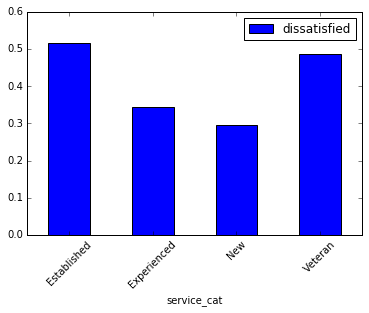

In [25]:
%matplotlib inline

dis = combined_updated.pivot_table(values = 'dissatisfied', index = 'service_cat')
dis.plot(kind = 'bar', rot = 45)

Based on our chart above, we can arrive at some answers to our initial first question:

1. Are employees who only worked for the institutes for a short period of time resigning due to some kind of dissatisfaction? What about employees who have been there longer?

According to the chart, the "New" category of dissatisfied employees accounts for around 30% of total "New" employees. So we can conclude that they are not usually leaving due to dissatisfaction. 

We also see that "Established" employees are over 50% leaving for dissatisfaction, and the "Veteran" employees are almost at 50% for dissatisfaction. So many more are leaving because of that versus "New" employees.

Now we need to clean data in the "age" column to answer our second question. We'll draw the line at 35 to discern between old and young employees:

In [26]:
combined_updated['age'].value_counts()

51-55            71
41-45            48
41  45           45
46-50            42
36-40            41
46  50           39
26-30            35
21  25           33
31  35           32
36  40           32
26  30           32
31-35            29
21-25            29
56 or older      29
56-60            26
61 or older      23
20 or younger    10
Name: age, dtype: int64

In [31]:
combined_updated['age'] = combined_updated['age'].astype(str).str.extract(r'(\d+)').astype(float)
combined_updated['age'].value_counts(dropna = False)

def age_sort(value):
    if value > 35: 
        return "Old"
    if pd.isnull(value):
        return np.nan
    else:
        return 'Young'
    
combined_updated['age_cat'] = combined_updated['age'].apply(age_sort)
combined_updated['age_cat'] = combined_updated['age_cat'].fillna('Old')
combined_updated['age_cat'].value_counts(dropna = False)


/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':
/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

Old      451
Young    200
Name: age_cat, dtype: int64

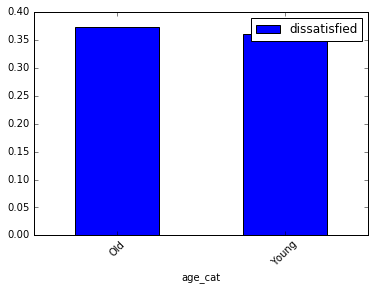

In [32]:
dis = combined_updated.pivot_table(values = 'dissatisfied', index = 'age_cat')
dis.plot(kind = 'bar', rot = 45)

The chart above answers our second question:

2. Are younger employees resigning due to some kind of dissatisfaction? What about older employees?

The chart shows both old and young employees at a very similar percentage leaving due to dissatisfaction (around 37%). This is not a majority on either front. It could be beneficial to sort out more age categories to see if there is a higher percentage as we further categorize the data. 